## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Note: This notebook excludes distortion correction steps as simulator produces distortionless images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

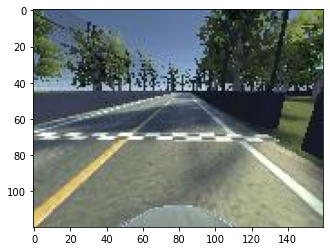

In [2]:
image_path = "test_images/"
# Make a list of test images
images = glob.glob(image_path+'*.jpg')

clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))

# Step through the list and save each image in LAB color space (useful for finding thresholds)
for fname in images:
    image_file = fname.split('\\')[-1] #If using Linux will need to change to '/'

    img = cv2.imread(fname)

    dst_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = dst_img[:,:,0]
    # Adaptive histogram equalization to compensate lighting conditions
    l_channel = clahe.apply(l_channel)

    dst_img[:,:,0] = l_channel

    cv2.imwrite('output_images/'+image_file.split('.')[0]+'_lab.jpg',dst_img)


# Test image
img = cv2.imread(images[-1])
img_size = (img.shape[1], img.shape[0])
    
dst_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Visualize undistorted image
plt.imshow(dst_img)

## Use color transforms, gradients, etc., to create a thresholded binary image.

Useful functions for producing the binary pixel of interest images to feed into the LaneTracker algorithm

In [3]:
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    # Apply threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(sobelx, sobely, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gradmag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    # Apply threshold
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output = np.zeros_like(sobelx)
        # Apply threshold
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(image_channel, thresh=(0,255)):
    binary_output = np.zeros_like(image_channel)
    binary_output[(image_channel >= thresh[0]) & (image_channel <= thresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# Edit this function to create your own pipeline.
# Note: This expects RGB images
def pipeline(image, l_thresh=(210, 255), b_thresh=(170, 255), grad_thresh=(30, 255), dir_thresh=(0, np.pi*0.40)):
    # Convert to LAB color space and separate the L and B channels
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel = lab[:,:,0]
    b_channel = lab[:,:,2]
    
    # Adaptive histogram equalization to compensate lighting conditions
    l_channel = clahe.apply(l_channel)
    
    # Choose a Sobel kernel size
    sobel_kernel = 11 # Choose a larger odd number to smooth gradient measurements

    # Calculating sobelx and sobely once to speed up processing
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
     
    # process image and generate binary pixel of interests

    # Threshold gradient magnitude
    grad_mag = mag_thresh(sobelx, sobely, mag_thresh=grad_thresh)
    # Threshold gradient direction
    grad_dir = dir_threshold(sobelx, sobely, thresh=dir_thresh)
    
    # Threshold color channel for white lanes
    l_binary = color_threshold(l_channel, thresh=l_thresh)
    
    # Threshold color channel for yellow lanes
    b_binary = color_threshold(b_channel, thresh=b_thresh)

    # Combine the binary thresholds
    combined_binary = np.zeros_like(image[:,:,0])
    combined_binary[((grad_mag==1)&(grad_dir==1)&(l_binary==1))|(b_binary == 1)] = 255

    return combined_binary

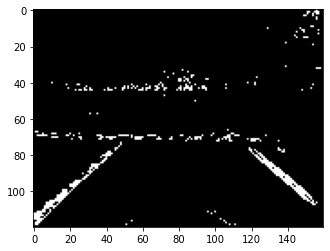

In [4]:
# TODO: You need to adjust L and B thresholds below according to color range of lane lines
thresholds = {}
thresholds['l_thresh']=(230, 255)
thresholds['b_thresh']=(170, 255)
thresholds['grad_thresh']=(10, 255)
thresholds['dir_thresh']=(np.pi*0.10, np.pi*0.40)

result = pipeline(dst_img, thresholds['l_thresh'], thresholds['b_thresh'], thresholds['grad_thresh'], thresholds['dir_thresh'])
cv2.imwrite('output_images/binary_combo_example.jpg',result)

# Visualize binary image
plt.imshow(result,cmap='gray')

In [5]:
# Step through the list and save each binary image
for fname in images:
    image_file = fname.split('\\')[-1] #If using Linux will need to change to '/'

    image = cv2.imread(fname)

    undst_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    binary_img = pipeline(undst_img, thresholds['l_thresh'], thresholds['b_thresh'], thresholds['grad_thresh'], thresholds['dir_thresh'])

    cv2.imwrite('output_images/binary_'+image_file,binary_img)

## Apply a perspective transform to rectify binary image to create a "birds-eye view"

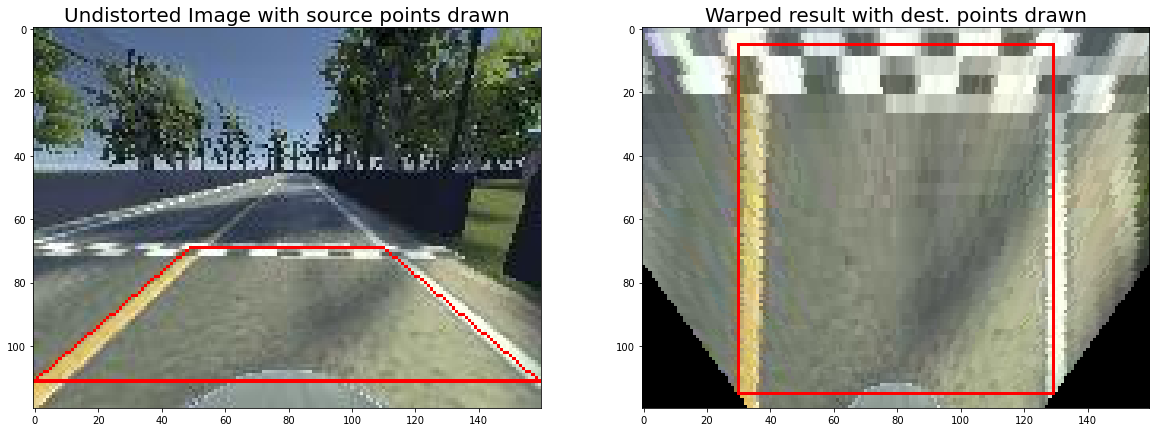

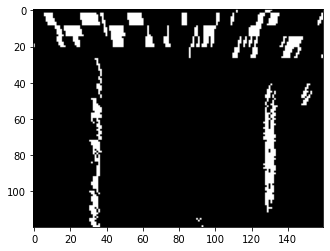

In [6]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

src = np.float32([[0,111],[49,69],[110,69],[159,111]])
dst = np.float32([[30,115],[30,5],[129,5],[129,115]])

top_down = warper(dst_img,src,dst)

cv2.polylines(dst_img, np.int32([src]), True, (255,0,0), 1)
cv2.polylines(top_down, np.int32([dst]), True, (255,0,0), 1)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst_img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Warped result with dest. points drawn', fontsize=20)
f.savefig('output_images/warped_straight_lines.jpg')
plt.show()

warped = warper(result,src,dst)

# Visualize binary image
plt.imshow(warped, cmap='gray')

In [7]:
# Step through the list and save each warped image
for fname in images:
    image_file = fname.split('\\')[-1] #If using Linux will need to change to '/'

    image = cv2.imread(fname)

    undst_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    binary_img = pipeline(undst_img, thresholds['l_thresh'], thresholds['b_thresh'], thresholds['grad_thresh'], thresholds['dir_thresh'])
    warped_img = warper(binary_img,src,dst)

    cv2.imwrite('output_images/warped_'+image_file,warped_img)

### Detect lane pixels and fit to a polynomial function to find the lane boundary.

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # y values of the last n fits of the line
        self.recent_yfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the fitted line of averaged x values of the fitted lines of last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = [] 
        #y values for detected line pixels
        self.ally = []
        
        self.yvals = None
        
    def fit_line(self, smooth_factor, margin):
        allx_smooth = np.concatenate(self.allx[-smooth_factor:]).ravel()
        ally_smooth = np.concatenate(self.ally[-smooth_factor:]).ravel()
        
        if len(self.allx) > smooth_factor*2:
            self.allx = self.allx[-smooth_factor:] # clip off to reduce memory
        if len(self.ally) > smooth_factor*2:
            self.ally = self.ally[-smooth_factor:] # clip off to reduce memory
        # Fit a second order polynomial to pixel positions in each lane line
        if(len(self.allx[-1])>150):
            previous_fit = self.current_fit
            self.current_fit = np.polyfit(ally_smooth, allx_smooth, 2)
            if self.detected:
                self.diffs = self.current_fit - previous_fit
            fitx = self.current_fit[0]*self.yvals*self.yvals + self.current_fit[1]*self.yvals + self.current_fit[2]
            fitx = np.array(fitx,np.int32)
            #Sanity check on polynomial fit
            if self.best_fit is not None:
                fitx = self.filter_fitx(fitx, margin)
            if fitx is not None:
                self.detected = True
                self.recent_xfitted.append(fitx)
                self.bestx = np.average(self.recent_xfitted[-smooth_factor:],axis = 0)
                self.best_fit = np.polyfit(self.yvals, self.bestx, 2)
                if len(self.recent_xfitted) > smooth_factor*2:
                    self.recent_xfitted = self.recent_xfitted[-smooth_factor:] # clip off to reduce memory
                if len(self.recent_yfitted) > smooth_factor*2:
                    self.recent_yfitted = self.recent_yfitted[-smooth_factor:] # clip off to reduce memory
        else:
            self.detected = False
        
    def filter_fitx(self, fitx, margin):
        run_len = max(self.ally[-1])-min(self.ally[-1])
        if not self.detected and len(self.allx[-1])>len(fitx)/2 and run_len > len(fitx)/3:
            for i in range(len(fitx)):
                x_min = self.bestx[i] - margin*3
                x_max = self.bestx[i] + margin*3
                fitx[i] = max(x_min,min(fitx[i],x_max))
            
            return fitx

        if abs(self.bestx[0] - fitx[0]) > margin and run_len < len(fitx)/4:
            self.detected = False
            return None
        if abs(self.bestx[-1] - fitx[-1]) > margin and run_len < len(fitx)/4:
            self.detected = False
            return None
        if abs(self.bestx[0] - fitx[0]) > 2.5*margin:
            self.detected = False
            return None
        if abs(self.bestx[-1] - fitx[-1]) > 2.5*margin:
            self.detected = False
            return None
        for i in range(len(fitx)):
            x_min = self.bestx[i] - margin
            x_max = self.bestx[i] + margin
            fitx[i] = max(x_min,min(fitx[i],x_max))
        
        return fitx
        

class LineTracker():

    # when starting a new instance please be sure to specify all unassigned variables
    def __init__(self, window_width, window_height, margin, ym = 1, xm =1, smooth_factor=15, lane_width=3.7):


        # the window pixel width of the center values, used to count pixels inside center windows to determine curve values
        self.window_width = window_width

        # the window pixel height of the center values, used to count pixels inside center windows to determine curve values
        # breaks the image into vertical levels
        self.window_height = window_height

        # The pixel distance in both directions to slide (left_window + right_window) template for searching
        self.margin = margin

        self.ym_per_pix = ym # meters per pixel in vertical axis

        self.xm_per_pix = xm # meters per pixel in horizontal axis
        
        self.smooth_factor = smooth_factor
        
        self.lane_width = lane_width
        
        self.left_line = Line()
        self.right_line = Line()

    # the main tracking function for finding and storing lane segment positions
    def find_lane_pixels(self, warped):

        if self.left_line.detected == False or self.right_line.detected == False:
            # window settings
            window_width = self.window_width
            window_height = self.window_height
            margin = self.margin # How much to slide left and right for searching

            window = np.ones(window_width) # Create our window template that we will use for convolutions

            # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
            # and then np.convolve the vertical image slice with the window template

            # Sum one third from bottom of image to get slice, could use a different ratio
            l_sum = np.sum(warped[int(2*warped.shape[0]/3):,:int(warped.shape[1]/2)], axis=0)
            l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
            r_sum = np.sum(warped[int(2*warped.shape[0]/3):,int(warped.shape[1]/2):], axis=0)
            r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
        
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []
        
            # Go through each layer looking for max pixel locations
            for level in range((int)(warped.shape[0]/window_height)):
                # convolve the window into the vertical slice of the image
                image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
                conv_signal = np.convolve(window, image_layer)
                # Find the best left centroid by using past left center as a reference
                # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
                offset = window_width/2
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
                if np.max(conv_signal[l_min_index:l_max_index]) > 10000:
                    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                # Find the best right centroid by using past right center as a reference
                r_min_index = int(max(r_center+offset-margin,0))  
                r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
                if np.max(conv_signal[r_min_index:r_max_index]) > 10000:
                    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
                # Identify window boundaries in x and y (and right and left)
                win_y_low = int(warped.shape[0]-(level+1)*window_height)
                win_y_high = int(warped.shape[0]-(level)*window_height)
                win_xleft_low = l_center - offset
                win_xleft_high = l_center + offset
                win_xright_low = r_center - offset
                win_xright_high = r_center + offset
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
            
            
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        
            # Extract left and right line pixel positions
            self.left_line.allx.append(nonzerox[left_lane_inds])
            self.left_line.ally.append(nonzeroy[left_lane_inds])
            self.right_line.allx.append(nonzerox[right_lane_inds])
            self.right_line.ally.append(nonzeroy[right_lane_inds])
            
            return self.left_line, self.right_line
        else:
            # It's now much easier to find line pixels!
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = self.margin
            
            left_fit = self.left_line.best_fit
            right_fit = self.right_line.best_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                              & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                               & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            self.left_line.allx.append(nonzerox[left_lane_inds])
            self.left_line.ally.append(nonzeroy[left_lane_inds])
            self.right_line.allx.append(nonzerox[right_lane_inds])
            self.right_line.ally.append(nonzeroy[right_lane_inds])
            
            return self.left_line, self.right_line
    
    def find_lines(self,warped):
        self.find_lane_pixels(warped)
        yvals = range(0,warped.shape[0])
        
        self.left_line.yvals = yvals
        self.right_line.yvals = yvals
    
        # Fit a second order polynomial to pixel positions in each lane line
        self.left_line.fit_line(self.smooth_factor, self.margin)            
        self.right_line.fit_line(self.smooth_factor, self.margin)
        
        self.lane_sanity_checks()
        
        if self.left_line.detected:
            self.left_line.line_base_pos = (self.left_line.bestx[-1]-warped.shape[1]/2)*self.xm_per_pix
        if self.right_line.detected:
            self.right_line.line_base_pos = (self.right_line.bestx[-1]-warped.shape[1]/2)*self.xm_per_pix
        
        return self.left_line, self.right_line
    
    def lane_sanity_checks(self):
        lane_width_near = (self.right_line.bestx[-1] - self.left_line.bestx[-1])*self.xm_per_pix
        if lane_width_near < self.lane_width*0.8 or lane_width_near > self.lane_width*1.2:
            self.left_line.detected = False
            self.right_line.detected = False
        lane_width_far = (self.right_line.bestx[0] - self.left_line.bestx[0])*self.xm_per_pix
        if lane_width_far < self.lane_width*0.5 or lane_width_far > self.lane_width*1.6:
            self.left_line.detected = False
            self.right_line.detected = False
        lane_width_mid = (self.right_line.bestx[(int)(len(self.right_line.bestx)/2)] - self.left_line.bestx[(int)(len(self.left_line.bestx)/2)])*self.xm_per_pix
        if lane_width_mid < self.lane_width*0.65 or lane_width_mid > self.lane_width*1.4:
            self.left_line.detected = False
            self.right_line.detected = False
    
    # Note: This returns a bird eye view of road.
    def get_road_img(self, warped):
        # Create an image to draw on and an image to show the selection window
        road_img = np.zeros_like(warped)
        road_img = np.array(cv2.merge((road_img,road_img,road_img)),np.uint8)
            
        if self.left_line.detected and self.right_line.detected:
            # Fit a second order polynomial to each
            left_fit = self.left_line.best_fit
            right_fit = self.right_line.best_fit
            # Generate x and y values for plotting
            ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

   
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            lane_pts = np.hstack((left_line_window2, right_line_window1))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(road_img, np.int_([left_line_pts]), (255,0, 0))
            cv2.fillPoly(road_img, np.int_([right_line_pts]), (0,0, 255))
            cv2.fillPoly(road_img, np.int_([lane_pts]), (0,255, 0))
        
        return road_img

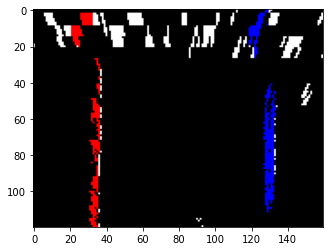

In [9]:
tracker_params = {}
tracker_params['window_width']=12
tracker_params['window_height']=20
tracker_params['margin']=10
tracker_params['ym_per_pix']=10/160
tracker_params['xm_per_pix']=3.7/(dst[2][0]-dst[1][0])

# Set up the overall class to do all the tracking
curve_centers = LineTracker(window_width = tracker_params['window_width'], window_height = tracker_params['window_height'], margin = tracker_params['margin'], ym = tracker_params['ym_per_pix'], xm = tracker_params['xm_per_pix'])
left_line, right_line = curve_centers.find_lane_pixels(warped)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))

out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]
plt.imshow(out_img)

f_right(y) = (-0.0013)*y^2+(0.211)*y+(121.4)
f_left(y) = (-0.0015)*y^2+(0.245)*y+(24.9)


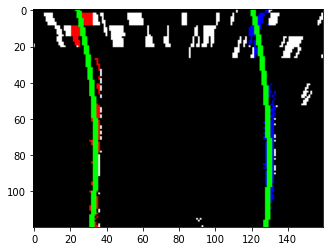

In [10]:
# fit the lane boundaries to the left,right center positions found
left_line, right_line = curve_centers.find_lines(warped)

left_lane = np.array(list(zip(np.concatenate((left_line.bestx-1,left_line.bestx[::-1]+1),axis=0),np.concatenate((left_line.yvals,left_line.yvals[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_line.bestx-1,right_line.bestx[::-1]+1),axis=0),np.concatenate((right_line.yvals,right_line.yvals[::-1]),axis=0))),np.int32)

cv2.fillPoly(out_img,[left_lane],color=[0,255,0])
cv2.fillPoly(out_img,[right_lane],color=[0,255,0])

print('f_right(y) = ('+str(round(right_line.current_fit[0],4))+')*y^2+('+str(round(right_line.current_fit[1],3))+')*y+('+str(round(right_line.current_fit[2],1))+')')
print('f_left(y) = ('+str(round(left_line.current_fit[0],4))+')*y^2+('+str(round(left_line.current_fit[1],3))+')*y+('+str(round(left_line.current_fit[2],1))+')')
    
# Visualize binary image with line fit
plt.imshow(out_img)

In [11]:
# Step through the list and save each image with fitted line
for fname in images:
    image_file = fname.split('\\')[-1] #If using Linux will need to change to '/'

    image = cv2.imread(fname)

    undst_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    binary_img = pipeline(undst_img, thresholds['l_thresh'], thresholds['b_thresh'], thresholds['grad_thresh'], thresholds['dir_thresh'])
    warped_img = warper(binary_img,src,dst)
    
    curve_centers = LineTracker(window_width = tracker_params['window_width'], window_height = tracker_params['window_height'], margin = tracker_params['margin'], ym = tracker_params['ym_per_pix'], xm = tracker_params['xm_per_pix'])
    left_line, right_line = curve_centers.find_lines(warped_img)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_img, warped_img, warped_img))

    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    left_lane = np.array(list(zip(np.concatenate((left_line.bestx-1,left_line.bestx[::-1]+1),axis=0),np.concatenate((left_line.yvals,left_line.yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_line.bestx-1,right_line.bestx[::-1]+1),axis=0),np.concatenate((right_line.yvals,right_line.yvals[::-1]),axis=0))),np.int32)

    cv2.fillPoly(out_img,[left_lane],color=[0,255,0])
    cv2.fillPoly(out_img,[right_lane],color=[0,255,0])
    
    #cv2.putText(out_img, 'f_right(y) = ('+str(round(right_line.current_fit[0],4))+')*y^2+('+str(round(right_line.current_fit[1],3))+')*y+('+str(round(right_line.current_fit[2],1))+')',(500,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    #cv2.putText(out_img, 'f_left(y) = ('+str(round(left_line.current_fit[0],4))+')*y^2+('+str(round(left_line.current_fit[1],3))+')*y+('+str(round(left_line.current_fit[2],1))+')',(50,500),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    
    out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite('output_images/'+image_file.split('.')[0] +'_fit_lines.jpg',out_img)

### Warp the detected lane boundaries back onto the original image.

In [12]:
def map_lane(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image

    return warped

### Determine the curvature of the lane and vehicle position with respect to center and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

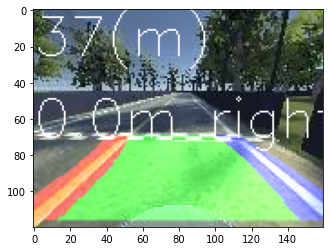

In [13]:
# This expects RGB images
def process_image(img, src, dst, thresholds, tracker):

    result = pipeline(img, thresholds['l_thresh'], thresholds['b_thresh'], thresholds['grad_thresh'], thresholds['dir_thresh'])
    warped = warper(result,src,dst)
    
    left_line, right_line = tracker.find_lines(warped)
    
    road_img = tracker.get_road_img(warped)   
   
    road_warped = map_lane(road_img,src,dst)

    result = cv2.addWeighted(img,1.0,road_warped,0.5,0.0)

    if left_line.detected and right_line.detected:
        ym_per_pix = tracker.ym_per_pix # meters per pixel in y dimension
        xm_per_pix = tracker.xm_per_pix # meters per pixel in x dimension

        curve_fit_cr = np.polyfit(np.array(left_line.yvals,np.float32)*ym_per_pix,np.array(left_line.bestx+right_line.bestx,np.float32)*xm_per_pix/2.0,2)
        curverad = ((1 + (2*curve_fit_cr[0]*left_line.yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])

        # calculate the offset of the car on the road
        center_diff = (left_line.line_base_pos + right_line.line_base_pos)/2
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        # draw the text showing curvature, offset, and speed
        cv2.putText(result, str(int(curverad))+'(m)',(0,25),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1)
        cv2.putText(result, str(abs(round(center_diff,2)))+'m '+side_pos ,(0,70),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1)
            
    return result

tracker_params['margin']=10

# Set up the overall class to do all the tracking
curve_centers = LineTracker(window_width = tracker_params['window_width'], window_height = tracker_params['window_height'], margin = tracker_params['margin'], ym = tracker_params['ym_per_pix'], xm = tracker_params['xm_per_pix'])

result = process_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), src, dst, thresholds, curve_centers)

# Visualize processed image
plt.imshow(result)

In [14]:
# Step through the list and save each processed image
for fname in images:
    image_file = fname.split('\\')[-1] #If using Linux will need to change to '/'

    image = cv2.imread(fname)
    
    curve_centers = LineTracker(window_width = tracker_params['window_width'], window_height = tracker_params['window_height'], margin = tracker_params['margin'], ym = tracker_params['ym_per_pix'], xm = tracker_params['xm_per_pix'])

    result = process_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), src, dst, thresholds, curve_centers)

    result_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite('output_images/'+image_file.split('.')[0] +'_output.jpg',result_img)